# Zero-shot Text Classification with SetFit

Although SetFit was designed for few-shot learning, the method can also be applied in scenarios where no labeled data is available. The main trick is to create _synthetic examples_ that resemble the classification task, and then train a SetFit model on them. 

Remarkably, this simple technique typically outperforms the zero-shot pipeline in 🤗 Transformers, and can generate predictions by a factor of 5x (or more) faster!

In this notebook, we'll explore how:

* SetFit can be applied for zero-shot classification
* Adding synthetic examples can also provide a performance boost to few-shot classification.

## Setup

If you're running this Notebook on Colab or some other cloud platform, you will need to install the `setfit` library. Uncomment the following cell and run it:

In [ ]:
# %pip install setfit matplotlib

To benchmark the performance of the "zero-shot" method, we'll use the following dataset and pretrained model: 

In [1]:
dataset_id = "emotion"
model_id = "sentence-transformers/paraphrase-mpnet-base-v2"

Next, we'll download the reference dataset from the Hugging Face Hub:

In [2]:
from datasets import load_dataset

reference_dataset = load_dataset(dataset_id)
reference_dataset

Using custom data configuration default
Reusing dataset emotion (/home/lewis/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

Now that we're set up, let's create some synthetic data to train on!

## Creating a synthetic dataset

The first thing we need to do is create a dataset of synthetic examples. In `setfit`, we can do this by applying the `add_templated_examples()` function to a dummy dataset. This function expects a few main things:

* A list of candidate labels to classify with. We'll use the labels from the reference dataset here, but this could be anything that's relevant to the task and dataset at hand.
* A template to generate examples with. By default, it is `"This sentence is {}"`, where the `{}` will be filled by one of the candidate labels
* A sample size $N$, which will create $N$ synthetic examples per class. We find $N=8$ usually works best.

Armed with this information, let's first extract some candidate labels from the dataset:

In [3]:
# Extract ClassLabel feature from "label" column
label_features = reference_dataset["train"].features["label"]
# Label names to classify with
candidate_labels = label_features.names
candidate_labels

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

**Note:** some datasets on the Hugging Face Hub don't have a `ClassLabel` feature for the label column. In these cases, you should compute the candidate labels manually by first computing the id2label mapping as follows:

```python
def get_id2label(dataset):
    # The column with the label names
    label_names = dataset.unique("label_text")
    # The column with the label IDs
    label_ids = dataset.unique("label")
    id2label = dict(zip(label_ids, label_names))
    # Sort by label ID
    return {key: val for key, val in sorted(id2label.items(), key = lambda x: x[0])}

id2label = get_id2label(reference_dataset["train"])
candidate_labels = list(id2label.values())
```

Now that we have the labels, it's a simple matter to create synthetic examples:

In [4]:
from datasets import Dataset
from setfit import add_templated_examples

# A dummy dataset to fill with synthetic examples
dummy_dataset = Dataset.from_dict({})
train_dataset = add_templated_examples(dummy_dataset, candidate_labels=candidate_labels, sample_size=8)
train_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 48
})

**Tip:** you might find you can get better performance by tweaking the `template` argument from the default of `"The sentence is {}"` to variants like `"This sentence is {}"` or `"This example is {}"`.

Since our dataset has 6 classes and we chose a sample size of 8, our synthetic dataset contains $6\times 8=48$ examples. If we take a look at a few of the examples:

In [5]:
train_dataset.shuffle()[:3]

{'text': ['This sentence is love',
  'This sentence is fear',
  'This sentence is joy'],
 'label': [2, 4, 1]}

we can see that each input takes the form of the template and has a corresponding label associated with it. 

Let's not train a SetFit model on these examples!

## Fine-tuning the model

To train a SetFit model, the first thing to do is download a pretrained checkpoint from the Hub. We can do so by using the `from_pretrained()` method associated with the `SetFitModel` class:

In [6]:
from setfit import SetFitModel

model = SetFitModel.from_pretrained(model_id)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Here, we've downloaded a pretrained Sentence Transformer from the Hub and added a logistic classification head to the create the SetFit model. As indicated in the message, we need to train this model on some labeled examples. We can do so by using the `SetFitTrainer` class as follows:

In [7]:
from setfit import SetFitTrainer

trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=reference_dataset["test"]
)

Now that we've created a trainer, we can train it! While we're at it, let's time how long it takes to train and evaluate the model:

In [8]:
%%time
trainer.train()
zeroshot_metrics = trainer.evaluate()
zeroshot_metrics

***** Running training *****
  Num examples = 1920
  Num epochs = 1
  Total optimization steps = 120
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/120 [00:00<?, ?it/s]

***** Running evaluation *****


CPU times: user 12.9 s, sys: 2.37 s, total: 15.2 s
Wall time: 11 s


{'accuracy': 0.5345}

Great, now that we have a reference score let's compare against the zero-shot pipeline from 🤗 Transformers.

## Comparing against the zero-shot pipeline from 🤗 Transformers

🤗 Transformers provides a zero-shot pipeline that frames text classification as a natural language inference task. Let's load the pipeline and place it on the GPU for fast inference: 

In [9]:
from transformers import pipeline

pipe = pipeline("zero-shot-classification", device=0)

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


Now that we have the model, let's generate some predictions. We'll use the same candidate labels as we did with SetFit and increase the batch size for to speed things up: 

In [10]:
%%time
zeroshot_preds = pipe(reference_dataset["test"]["text"], batch_size=16, candidate_labels=candidate_labels)

CPU times: user 1min 10s, sys: 166 ms, total: 1min 11s
Wall time: 53.1 s


Note that this took almost 5x longer to generate predictions than SetFit! OK, so how well does it perform? Since each prediction is a dictionary of label names ranked by score:

In [11]:
zeroshot_preds[0]

{'sequence': 'im feeling rather rotten so im not very ambitious right now',
 'labels': ['sadness', 'anger', 'surprise', 'fear', 'joy', 'love'],
 'scores': [0.7367985844612122,
  0.10041674226522446,
  0.09770156443119049,
  0.05880110710859299,
  0.004266355652362108,
  0.0020156768150627613]}

we can use the `str2int()` function from the `label` column to convert them to integers. 

In [12]:
preds = [label_features.str2int(pred["labels"][0]) for pred in zeroshot_preds]

**Note:** As noted earlier, if you're using a dataset that doesn't have a `ClassLabel` feature for the label column, you'll need to compute the label mapping manually with something like:

```python
id2label = get_id2label(reference_dataset["train"])
label2id = {v:k for k,v in id2label.items()}
preds = [label2id[pred["labels"][0]] for pred in zeroshot_preds]
```

The last step is to compute accuracy using 🤗 Evaluate:

In [13]:
import evaluate

metric = evaluate.load("accuracy")
transformers_metrics = metric.compute(predictions=preds, references=reference_dataset["test"]["label"])
transformers_metrics

{'accuracy': 0.3765}

Compared to SetFit, this approach performs significantly worse. Let's wrap up our analysis by combining synthetic examples with a few labeled ones.

## Augmenting labeled data with synthetic examples

If you have a few labeled examples, adding synthetic data can often boost performance. To simulate this, let's first sample 8 labeled examples from our reference dataset:

In [14]:
from setfit import sample_dataset

train_dataset = sample_dataset(reference_dataset["train"])
train_dataset

Loading cached shuffled indices for dataset at /home/lewis/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705/cache-5cdfbd5e800ffaf7.arrow
Parameter 'function'=<function sample_dataset.<locals>.<lambda> at 0x7f2a0fa8be20> of the transform datasets.arrow_dataset.Dataset.filter@2.0.1 couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

Dataset({
    features: ['text', 'label'],
    num_rows: 48
})

To warm up, we'll train a SetFit model on these true labels:

In [15]:
model = SetFitModel.from_pretrained(model_id)

trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=reference_dataset["test"]
)
trainer.train()
fewshot_metrics = trainer.evaluate()
fewshot_metrics

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 1920
  Num epochs = 1
  Total optimization steps = 120
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/120 [00:00<?, ?it/s]

***** Running evaluation *****


{'accuracy': 0.4705}

Note that for this particular dataset, the performance with true labels is _worse_ than training on synthetic examples! In our experiments, we found that the difference depends strongly on the dataset in question. Since SetFit models are fast to train, you can always try both approaches and pick the best one.

In any case, let's now add some synthetic examples to our training set:

In [16]:
augmented_dataset = add_templated_examples(train_dataset, candidate_labels=candidate_labels, sample_size=8)
augmented_dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 96
})

As before, we can train and evaluate SetFit with the augmented dataset:

In [17]:
model = SetFitModel.from_pretrained(model_id)

trainer = SetFitTrainer(
    model=model,
    train_dataset=augmented_dataset,
    eval_dataset=reference_dataset["test"]
)
trainer.train()
augmented_metrics = trainer.evaluate()
augmented_metrics

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 3840
  Num epochs = 1
  Total optimization steps = 240
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/240 [00:00<?, ?it/s]

***** Running evaluation *****


{'accuracy': 0.613}

Great, this has given us a significant boost in performance and given us a few percentage points over the purely synthetic example. 

Let's plot the final results for comparison:

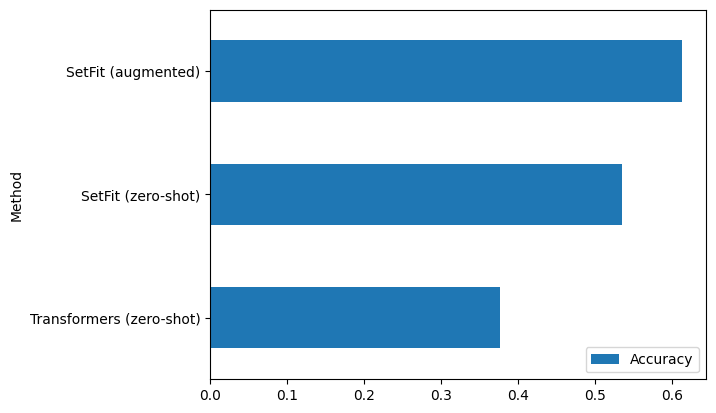

In [18]:
import pandas as pd

df = pd.DataFrame.from_dict({"Method":["Transformers (zero-shot)", "SetFit (zero-shot)", "SetFit (augmented)"], "Accuracy": [transformers_metrics["accuracy"], zeroshot_metrics["accuracy"], augmented_metrics["accuracy"]]})
df.plot(kind="barh", x="Method");                                       